In [1]:
# Simple RNN-LSTM regression
# 2017-03-16 jkang
# Python3.5
# Tensorflow1.0.1
#
# input: sinewaves (varying frequency, amplitude and duration)
# output: one-sample shifted inputs
#
# no batch mode (online training)

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Input, Ouput dataset
n_examples = 100
srate = 10  # Hz
sin_in = {}
sin_out = {}
for i in range(n_examples):
    freq = np.random.random(1)/15 + 0.5  # 1 <= freq < 11 Hz
    amplitude = np.random.random(1) * 10
    duration = np.random.random(1) * 5 + 5  # sample from 5 ~ 10 sec
    t = np.linspace(0, duration, duration * srate + 1)
    sin = np.sin(2 * np.pi * freq * t) * amplitude
    key = 's' + str(i + 1)
    shift = int(srate/freq*1/4)
    sin_in[key] = sin[:-shift]
    sin_out[key] = sin[shift:]  # shifting

/Users/jaegukang/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py:10: DeprecationWarning: object of type <class 'numpy.ndarray'> cannot be safely interpreted as an integer.


In [4]:
# Hyper-Parameters
learning_rate = 0.001
max_iter = 100

# Network Parameters
n_input_dim = 1
n_input_len = len(sin_in)
n_output_len = len(sin_out)
n_hidden = 200
n_output_dim = 1

# TensorFlow graph
# (batch_size) x (time_step) x (input_dimension)
x = tf.placeholder(tf.float32, [1, None, n_input_dim])
# (batch_size) x (time_step) x (output_dimension)
y = tf.placeholder(tf.float32, [1, None, n_output_dim])

# Parameters
weights = {
    'out': tf.Variable(tf.random_normal([n_hidden, n_output_dim]))
}
biases = {
    'out': tf.Variable(tf.random_normal([n_output_dim]))
}

In [5]:
def RNN(inputs, weights, biases):
    # Reshape to (time_step) x (batch_size) x (input_dimension)
    inputs = tf.transpose(inputs, [1, 0, 2])
    # Reshape to (time_step)*(batch_size) x (input_dimension)
    inputs = tf.reshape(inputs, [-1, n_input_dim])
    # Split to get a list of time_step tensors of shape (batch_size, input_dimension)
    # final 'inputs' is a list of n_input_len elements (=number of frames)
    inputs = tf.split(
        value=inputs, num_or_size_splits=n_input_len, axis=0)

    lstm = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0)
    outputs, states = tf.nn.dynamic_rnn(lstm, x, dtype=tf.float32)
    return tf.matmul(outputs[-1], weights['out']) + biases['out']

pred = RNN(x, weights, biases)
cost = tf.reduce_mean(tf.squared_difference(pred, y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [6]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    step = 1
    while step <= max_iter:
        loss = 0
        for i in range(n_examples):
            key = 's' + str(i + 1)
            train_x = sin_in[key].reshape((1, len(sin_in[key]), n_input_dim))
            train_y = sin_out[key].reshape(
                (1, len(sin_out[key]), n_output_dim))
            c, _ = sess.run([cost, optimizer], feed_dict={
                            x: train_x, y: train_y})
            loss += c
        mean_mse = loss / n_examples

        print('Epoch =', str(step), '/', str(max_iter),
              'Cost = ', '{:.5f}'.format(mean_mse))
        step += 1

Epoch = 1 / 100 Cost =  2.30783
Epoch = 2 / 100 Cost =  0.92011
Epoch = 3 / 100 Cost =  0.71015
Epoch = 4 / 100 Cost =  0.57192
Epoch = 5 / 100 Cost =  0.48977
Epoch = 6 / 100 Cost =  0.43537
Epoch = 7 / 100 Cost =  0.39500
Epoch = 8 / 100 Cost =  0.35027
Epoch = 9 / 100 Cost =  0.32645
Epoch = 10 / 100 Cost =  0.30309
Epoch = 11 / 100 Cost =  0.28208
Epoch = 12 / 100 Cost =  0.26590
Epoch = 13 / 100 Cost =  0.25234
Epoch = 14 / 100 Cost =  0.24436
Epoch = 15 / 100 Cost =  0.23169
Epoch = 16 / 100 Cost =  0.23014
Epoch = 17 / 100 Cost =  0.22540
Epoch = 18 / 100 Cost =  0.24387
Epoch = 19 / 100 Cost =  0.23897
Epoch = 20 / 100 Cost =  0.21399
Epoch = 21 / 100 Cost =  0.19755
Epoch = 22 / 100 Cost =  0.19024
Epoch = 23 / 100 Cost =  0.18060
Epoch = 24 / 100 Cost =  0.17782
Epoch = 25 / 100 Cost =  0.17124
Epoch = 26 / 100 Cost =  0.16895
Epoch = 27 / 100 Cost =  0.16402
Epoch = 28 / 100 Cost =  0.16128
Epoch = 29 / 100 Cost =  0.15762
Epoch = 30 / 100 Cost =  0.15439
Epoch = 31 / 100 Co

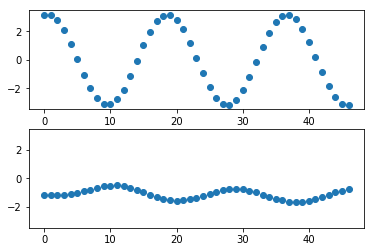

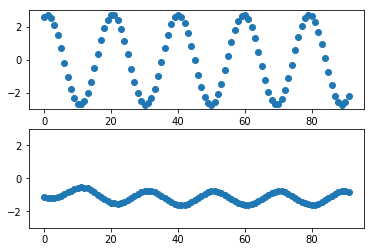

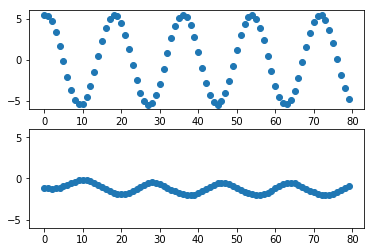

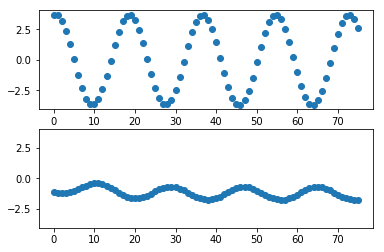

In [7]:
# Test
with tf.Session() as sess:
    sess.run(init)
    for i in np.arange(5)[1:]:
        idx = 's' + str(np.random.permutation(n_examples)[0])
        test_x = sin_in[idx].reshape((1, len(sin_in[idx]), n_input_dim))
        pred_out = sess.run(pred, feed_dict={x: test_x})
        f, axes = plt.subplots(2, sharey=True)
        axes[0].plot(sin_out[idx],'o')
        axes[1].plot(pred_out,'o')
        plt.show()
        #f.savefig('result_' + idx + '.png')

### Result  

When the model (RNN-LSTM) has to learn sinewaves varying in frequency, amplitude and duration, it doesn't correctly learn the input in the end.  
  
Possible conjectures:  
* Input patterns (i.e. frequency and amplitude) are so varaible that the model only tries to generalize the entire input patterns.
* Input data should be checked whether different patterns are balanced for training
* Time window for input might be needed to learn local shapes better